In [1]:
from cProfile import label
import time
import argparse
from xmlrpc.client import boolean
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import torch
import torch.nn.functional as F
import torch.optim as optimize 
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms

from torch.utils.data import DataLoader

from util.dataloader import IRT, IRTHybrid
from models.CNN import AlexNet, EfficientNet
import cv2 as cv
import glob

# For non hybrid data

In [2]:
dtype ='irt'
if dtype == 'irt':    
    df_images = pd.read_csv('thermal_mat.csv',index_col=0)
elif dtype == 'img':
    df_images = pd.read_csv('thermal_img.csv',index_col=0)

len(df_images)



2298

In [3]:
img_paths = df_images['path'].values
# irt_paths = df_irt['path'].values
labels_idx = df_images['label'].values

len(img_paths), np.unique(np.array(labels_idx)), img_paths[0]

(2298, array([0, 1, 2, 3]), 'data/0/60Hz/images/R20211104_2473.png')

In [4]:
x_train, x_test, y_train, y_test = train_test_split(img_paths, labels_idx,
                                                    test_size=0.2,
                                                    random_state=1234,
                                                    stratify=labels_idx)

len(x_train), len(x_test), len(y_train), len(y_test)                                                

(1838, 460, 1838, 460)

In [5]:
class args: pass
args.cuda = True
args.epochs = 2
args.batch_size = 16
args.dataAugmentation =False
args.log_interval=100
args.lr = 1e-4
args.momentum = 0.9
args.dtype = 'img'
args.seed = 1

In [7]:
data_path = '/home/edgomez10/Project/TB-and-IB-analysis-of-IRT-for-the-state-assessment-of-rolling-bearings-using-DL/data'

train_dataset=IRT(x_train, y_train, data_path, transform=None) #transforms.Compose([transforms.ToTensor()]), train_transforms
test_dataset=IRT(x_test, y_test, data_path, transform=None)#test_transforms

train_loader = DataLoader(train_dataset,batch_size=args.batch_size, shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=args.batch_size, shuffle=True)


print(f"There are {len(train_dataset)} train images and {len(test_dataset)} test images")

There are 1064 train images and 119 test images


In [16]:
# data_path = '/home/edgomez10/Project/TB-and-IB-analysis-of-IRT-for-the-state-assessment-of-rolling-bearings-using-DL/data2'

# train_dataset=IRT(img_paths, irt_paths, y_train, data_path, transform=None) #transforms.Compose([transforms.ToTensor()]), train_transforms
# test_dataset=IRT(x_test, y_test, data_path, transform=None)#test_transforms

# train_loader = DataLoader(train_dataset,batch_size=args.batch_size, shuffle=True)
# test_loader=DataLoader(test_dataset,batch_size=args.batch_size, shuffle=True)


# print(f"There are {len(train_dataset)} train images and {len(test_dataset)} test images")

In [9]:
list('[1,0,0]')

['[', '1', ',', '0', ',', '0', ']']

(480, 640, 3)


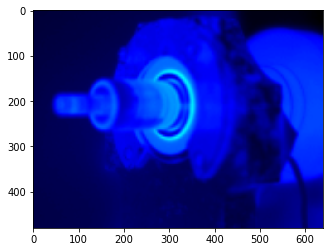

In [8]:
import matplotlib.pyplot as plt
img = cv.imread(x_train[0], cv.IMREAD_COLOR)
plt.imshow(img)
print(img.shape)

In [12]:
batches = []
# model = AlexNet(dtype=args.dtype)
# # model = EfficientNet(dtype, version='b0', num_classes=4)

gpuID = 1
# if args.cuda:
#         model = model.cuda(gpuID)
# g = torch.Generator()
# g.manual_seed(args.seed)
for batch_idx, (data,target) in enumerate(train_loader):
    # batches.append(batch_idx)
    # print(target)
    if args.cuda:
        data, target = data.cuda(gpuID), target.cuda(gpuID)
    print(type(data), data.shape)
    data, target = Variable(data), Variable(target)
    # scores = model(data)
# print(len(batches), len(inputs))

<class 'torch.Tensor'> torch.Size([16, 480, 640, 3])
<class 'torch.Tensor'> torch.Size([16, 480, 640, 3])
<class 'torch.Tensor'> torch.Size([16, 480, 640, 3])
<class 'torch.Tensor'> torch.Size([16, 480, 640, 3])
<class 'torch.Tensor'> torch.Size([16, 480, 640, 3])
<class 'torch.Tensor'> torch.Size([16, 480, 640, 3])
<class 'torch.Tensor'> torch.Size([16, 480, 640, 3])
<class 'torch.Tensor'> torch.Size([16, 480, 640, 3])
<class 'torch.Tensor'> torch.Size([16, 480, 640, 3])


KeyboardInterrupt: 

# For Hybrid Data

In [34]:
df_irt = pd.read_csv('thermal_matV4.csv',index_col=0)

df_images = pd.read_csv('thermal_imgV4.csv',index_col=0)

In [35]:
img_paths = df_images['path'].values
irt_paths = df_irt['path'].values
labels_idx = df_images['label'].values

len(img_paths), len(irt_paths), np.unique(np.array(labels_idx))

(1183, 1183, array([0, 1, 3]))

In [36]:
np.array([irt_paths]).T, np.array([img_paths]).T

(array([['data2/0/60Hz/thermal_mat/IR20211103_2310.csv'],
        ['data2/0/60Hz/thermal_mat/IR20211103_2434.csv'],
        ['data2/0/60Hz/thermal_mat/IR20211103_2346.csv'],
        ...,
        ['data2/3/60Hz/thermal_mat/IR20211117_3625.csv'],
        ['data2/3/60Hz/thermal_mat/IR20211117_3585.csv'],
        ['data2/3/60Hz/thermal_mat/IR20211117_3593.csv']], dtype=object),
 array([['data2/0/60Hz/images/IR20211103_2297.png'],
        ['data2/0/60Hz/images/IR20211104_2457.png'],
        ['data2/0/60Hz/images/IR20211103_2412.png'],
        ...,
        ['data2/3/60Hz/images/IR20211117_3638.png'],
        ['data2/3/60Hz/images/IR20211111_3017.png'],
        ['data2/3/60Hz/images/IR20211111_3041.png']], dtype=object))

In [37]:
data_paths = np.concatenate((np.array([irt_paths]).T, np.array([img_paths]).T), axis = 1)
data_paths.shape


(1183, 2)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(data_paths, labels_idx,
                                                    test_size=0.1,
                                                    random_state=1234,
                                                    stratify=labels_idx)

len(x_train), len(x_test), len(y_train), len(y_test)                                                

(1064, 119, 1064, 119)

In [39]:
class args: pass
args.cuda = True
args.epochs = 2
args.batch_size = 16
args.dataAugmentation =False
args.log_interval=100
args.lr = 1e-4
args.momentum = 0.9

In [42]:
data_path = '/home/edgomez10/Project/TB-and-IB-analysis-of-IRT-for-the-state-assessment-of-rolling-bearings-using-DL/data2'

train_dataset=IRTHybrid(x_train[:,1], x_train[:,0], y_train, data_path, transform=None) #transforms.Compose([transforms.ToTensor()]), train_transforms
test_dataset=IRTHybrid(x_test[:,1], x_test[:,0], y_test, data_path, transform=None)#test_transforms

train_dataset.__getitem__(0)[0].shape

(480, 640, 3)

In [25]:
train_loader = DataLoader(train_dataset,batch_size=args.batch_size, shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=args.batch_size, shuffle=True)


print(f"There are {len(train_dataset)} train images and {len(test_dataset)} test images")

There are 1064 train images and 119 test images


# DataLoader

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
img = cv.imread(x_train[0])
print(img)

[[[ 0  0  4]
  [ 0  0  4]
  [ 0  0  4]
  ...
  [ 0  0  8]
  [ 0  0  7]
  [ 0  0  7]]

 [[ 0  0  4]
  [ 0  0  4]
  [ 0  0  4]
  ...
  [ 0  0  5]
  [ 0  0  7]
  [ 0  0  7]]

 [[ 0  0  4]
  [ 0  0  4]
  [ 0  0  4]
  ...
  [ 0  0  5]
  [ 0  0  5]
  [ 0  0  7]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0 10]
  [ 0  0 10]
  [ 0  0 10]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0 10]
  [ 0  0 11]
  [ 0  0 15]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0 10]
  [ 0  0  7]
  [ 0  0 15]]]


In [3]:
import glob
test = 0
irt_list = glob.glob(os.path.join('data', str(test), '60Hz', 'images', '*.png'), recursive=True)
# irt_list = glob.glob(os.path.join('data', str(test), '60Hz', 'thermal_mat', direc, '*.csv'), recursive=True)

len(irt_list)#, irt_list[0]

537

In [5]:
import glob
test = 0
direc = 'lateral'
irt_list = glob.glob(os.path.join('data2', str(test), '60Hz', 'images', '*.png'), recursive=True)
# irt_list = glob.glob(os.path.join('data', str(test), '60Hz', 'thermal_mat', direc, '*.csv'), recursive=True)

len(irt_list)#, irt_list[0]

348

In [18]:
# df2 = pd.DataFrame(columns = ['path', 'category', 'label'])
df3 = pd.DataFrame(columns = ['path', 'category', 'label'])

In [26]:
test = 3
speed = '60Hz'
# irt_list = glob.glob(os.path.join('data', str(test), speed, 'images', '*.png'), recursive=True)
irt_list = glob.glob(os.path.join('data', str(test), speed, 'thermal_mat', '*.csv'), recursive=True)

print(len(irt_list))#, irt_list[0]
for i in range(len(irt_list)):
    dic = {'path': irt_list[i], 'category': f'S{irt_list[0][5]}', 'label': int(irt_list[0][5])}
    df3 = df3.append(dic, ignore_index = True)
df3.shape

639


(2298, 3)

In [24]:
# df2.to_csv(os.path.join('thermal_img.csv'), sep=',')
df3.to_csv(os.path.join('thermal_mat.csv'), sep=',')

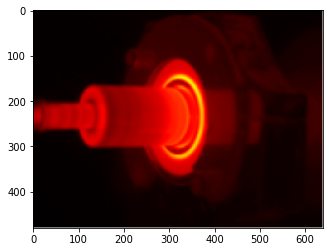

In [12]:
img = Image.open(x_train[0])
img = np.array(img, dtype=np.uint8)
plt.imshow(img)
